In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
raw_train = pd.read_csv('../data/train.csv',nrows=15000)

In [5]:
raw_train.drop('ID_code',inplace=True,axis=1)
raw_train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
y = raw_train['target']
x = raw_train.drop('target',axis=1)
features = raw_train.columns[1:]
del raw_train

In [7]:
min_max = MinMaxScaler()
scale_x = min_max.fit_transform(x)

In [8]:
scale_train = pd.DataFrame(scale_x)
scale_train.columns = features

In [9]:
scale_train.insert(0,'target',y)
del x
del scale_x
del y

In [10]:
scale_train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,0.445531,0.301550,0.571798,0.390435,0.585532,0.426455,0.497832,0.550445,0.260413,...,0.572986,0.336537,0.613930,0.438490,0.475805,0.259893,0.659950,0.404721,0.304616,0.566695
1,0,0.583300,0.421463,0.701510,0.413320,0.681198,0.779351,0.589293,0.445571,0.674662,...,0.685418,0.537011,0.562922,0.783047,0.294962,0.810846,0.668035,0.443761,0.610830,0.615673
2,0,0.428614,0.485151,0.583262,0.606898,0.492338,0.430771,0.830085,0.349443,0.260449,...,0.519352,0.647413,0.478635,0.438296,0.656023,0.948568,0.191065,0.353454,0.411264,0.590642
3,0,0.559749,0.512137,0.375245,0.553002,0.704799,0.587426,0.629732,0.364952,0.212096,...,0.574080,0.378107,0.390721,0.428459,0.739683,0.400027,0.308087,0.704136,0.589615,0.439419
4,0,0.494291,0.542508,0.636066,0.509846,0.672178,0.680038,0.647528,0.581754,0.834810,...,0.365215,0.633055,0.310560,0.717660,0.169638,0.370004,0.531274,0.567462,0.591136,0.442464


In [10]:
t_corr = scale_train[['target','var_0']].corr(method = 'kendall')
t_corr

,target,var_0
target,1.000000,0.038141
var_0,0.038141,1.000000


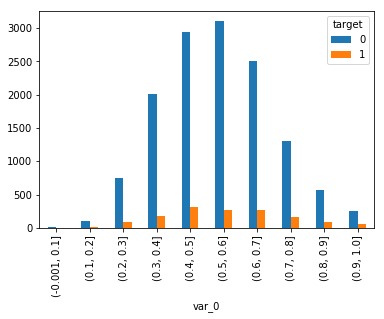

In [13]:
cross_v0 = pd.crosstab(pd.cut(scale_train['var_0'],10),scale_train['target'])
cross_v0.plot(kind='bar')
plt.show(block = False)